In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



[1] "covid19-case-surveillance-public-use-dataset"

In [2]:
library(tictoc)
tic()
data <- read.csv('../input/covid19-case-surveillance-public-use-dataset/COVID-19_Case_Surveillance_Public_Use_Data.csv')
#head(data)
dat <- data[, 4:11]
#head(dat)
toc()

74.234 sec elapsed


In [3]:
# rename columns for ease
colnames(dat) <- c("current_status", "sex", "age", "race_ethnicity", "hosp", "icu", "death", "medcond")

# determine unique vals in each column to identify those without information, or of insufficient frequency (e.g., sex == "Other")
for (col in 1:8){
    print(colnames(dat)[col])
    print(as.data.frame(table(dat[,col])))
}

[1] "current_status"
                       Var1    Freq
1 Laboratory-confirmed case 7910118
2             Probable Case  494961
[1] "sex"
     Var1    Freq
1  Female 4340898
2    Male 3970591
3 Missing   19520
4   Other     207
5 Unknown   73845
[1] "age"
            Var1    Freq
1    0 - 9 Years  299040
2  10 - 19 Years  841450
3  20 - 29 Years 1635264
4  30 - 39 Years 1372623
5  40 - 49 Years 1267350
6  50 - 59 Years 1227493
7  60 - 69 Years  863260
8  70 - 79 Years  483689
9      80+ Years  382869
10       Unknown   31952
[1] "race_ethnicity"
                                                  Var1    Freq
1          American Indian/Alaska Native, Non-Hispanic   59842
2                                  Asian, Non-Hispanic  143080
3                                  Black, Non-Hispanic  736584
4                                      Hispanic/Latino 1195739
5                                              Missing  601519
6                         Multiple/Other, Non-Hispanic  270509
7 Nati

In [4]:
# Make Dataframe without Missing/Unknown/Low-count values
df <- dat %>% filter(sex %in% c("Female", "Male"),
                     age != "Unknown",
                     race_ethnicity != "Unknown" & race_ethnicity != "Missing",
                     hosp %in% c("Yes", "No"),
                     icu %in% c("Yes", "No"),
                     death %in% c("Yes", "No"),
                     medcond %in% c("Yes", "No"))
for (col in 1:8){
    print(colnames(df)[col])
    print(as.data.frame(table(df[,col])))
}

[1] "current_status"
                       Var1   Freq
1 Laboratory-confirmed case 436557
2             Probable Case  21174
[1] "sex"
     Var1   Freq
1  Female 243408
2    Male 214323
3 Missing      0
4   Other      0
5 Unknown      0
[1] "age"
            Var1  Freq
1    0 - 9 Years 14431
2  10 - 19 Years 44214
3  20 - 29 Years 79663
4  30 - 39 Years 66249
5  40 - 49 Years 65790
6  50 - 59 Years 69645
7  60 - 69 Years 55535
8  70 - 79 Years 35232
9      80+ Years 26972
10       Unknown     0
[1] "race_ethnicity"
                                                  Var1   Freq
1          American Indian/Alaska Native, Non-Hispanic   1643
2                                  Asian, Non-Hispanic  13515
3                                  Black, Non-Hispanic  55636
4                                      Hispanic/Latino  97731
5                                              Missing      0
6                         Multiple/Other, Non-Hispanic  13544
7 Native Hawaiian/Other Pacific Islander, No

In [5]:

dim(df)
#dim(dat)



[1] 457731      8

This filtration reduced the dataframe from 8e6 to 4e5 rows.  The remaineder is still sufficient to perform analysis.

However, this is a dramatic reduction in data.  Which demographic groups have lost the most entries?

In [6]:
# investigate age bias
Afiltering <- cbind(as.data.frame(table(dat$age)),as.data.frame(table(df$age))[,2] )
colnames(Afiltering) <- c("age", "Freq1", "Freq2" )
Afiltering$percent_lost <- 100 * (1 - Afiltering[,3] / Afiltering[,2])
Afiltering

age,Freq1,Freq2,percent_lost
<fct>,<int>,<int>,<dbl>
0 - 9 Years,299040,14431,95.17422
10 - 19 Years,841450,44214,94.74550
20 - 29 Years,1635264,79663,95.12843
30 - 39 Years,1372623,66249,95.17355
40 - 49 Years,1267350,65790,94.80885
50 - 59 Years,1227493,69645,94.32624
60 - 69 Years,863260,55535,93.56683
70 - 79 Years,483689,35232,92.71598
80+ Years,382869,26972,92.95529


In [7]:
Akeeplose <- cbind(Afiltering$Age, Afiltering[,3], #keep
                    (Afiltering[,2] - Afiltering[,3]))[-10,] #lost, and removing 'Unknown' row
Akeeplose
prop.test(as.matrix(Akeeplose), correct = F)

14431,284609
44214,797236
79663,1555601
66249,1306374
65790,1201560
69645,1157848
55535,807725
35232,448457
26972,355897



	9-sample test for equality of proportions without continuity
	correction

data:  as.matrix(Akeeplose)
X-squared = 9304.8, df = 8, p-value < 2.2e-16
alternative hypothesis: two.sided
sample estimates:
    prop 1     prop 2     prop 3     prop 4     prop 5     prop 6     prop 7 
0.04825776 0.05254501 0.04871568 0.04826453 0.05191147 0.05673759 0.06433172 
    prop 8     prop 9 
0.07284019 0.07044707 


In [8]:
# investigate race_ethnic bias
REfiltering <- cbind(as.data.frame(table(dat$race_ethnicity)),as.data.frame(table(df$race_ethnicity))[,2] )
colnames(REfiltering) <- c("race_ethnicity", "Freq1", "Freq2" )
REfiltering$percent_lost <- 100 * (1 - REfiltering[,3] / REfiltering[,2])
REfiltering


race_ethnicity,Freq1,Freq2,percent_lost
<fct>,<int>,<int>,<dbl>
"American Indian/Alaska Native, Non-Hispanic",59842,1643,97.25444
"Asian, Non-Hispanic",143080,13515,90.55424
"Black, Non-Hispanic",736584,55636,92.44675
Hispanic/Latino,1195739,97731,91.82673
Missing,601519,0,100.00000
"Multiple/Other, Non-Hispanic",270509,13544,94.99314
"Native Hawaiian/Other Pacific Islander, Non-Hispanic",17213,2648,84.61628
Unknown,2781176,0,100.00000
"White, Non-Hispanic",2599410,273014,89.49708


In [9]:
Afilter<- Afiltering[1:9, c(1,4)]
REfilter <- REfiltering[c(-5,-8), c(1,4)]
Afilter
REfilter

,age,percent_lost
,<fct>,<dbl>
1,0 - 9 Years,95.17422
2,10 - 19 Years,94.74550
3,20 - 29 Years,95.12843
4,30 - 39 Years,95.17355
5,40 - 49 Years,94.80885
6,50 - 59 Years,94.32624
7,60 - 69 Years,93.56683
8,70 - 79 Years,92.71598
9,80+ Years,92.95529


,race_ethnicity,percent_lost
,<fct>,<dbl>
1,"American Indian/Alaska Native, Non-Hispanic",97.25444
2,"Asian, Non-Hispanic",90.55424
3,"Black, Non-Hispanic",92.44675
4,Hispanic/Latino,91.82673
6,"Multiple/Other, Non-Hispanic",94.99314
7,"Native Hawaiian/Other Pacific Islander, Non-Hispanic",84.61628
9,"White, Non-Hispanic",89.49708


In [10]:
RE_outcomes <- dat %>% group_by(race_ethnicity) %>% summarise(p_hosp = 100*mean(hosp == "Yes"),
                                                              p_icu = 100*mean(icu== "Yes"),
                                                              p_death = 100*mean(death == "Yes"))

Age_outcomes <- dat %>% group_by(age) %>% summarise(p_hosp = 100*mean(hosp == "Yes"), 
                                                    p_icu = 100*mean(icu== "Yes"),
                                                    p_death = 100*mean(death == "Yes"))
RE_outcomes <- as.data.frame(RE_outcomes)[c(-5,-8,-10),]
Age_outcomes <- as.data.frame(Age_outcomes)[1:9,]
RE_outcomes
Age_outcomes

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



,race_ethnicity,p_hosp,p_icu,p_death
,<fct>,<dbl>,<dbl>,<dbl>
1,"American Indian/Alaska Native, Non-Hispanic",7.551552,0.6149527,2.252599
2,"Asian, Non-Hispanic",11.229382,2.0603858,3.941152
3,"Black, Non-Hispanic",12.427503,1.4621550,3.870842
4,Hispanic/Latino,7.789994,0.8875683,1.919650
6,"Multiple/Other, Non-Hispanic",7.906576,0.7896225,2.313047
7,"Native Hawaiian/Other Pacific Islander, Non-Hispanic",9.516063,2.4864928,1.684773
9,"White, Non-Hispanic",7.392793,0.8290343,3.349760


,age,p_hosp,p_icu,p_death
,<fct>,<dbl>,<dbl>,<dbl>
1,0 - 9 Years,1.487426,0.12439807,0.02374264
2,10 - 19 Years,0.860776,0.06869095,0.01604373
3,20 - 29 Years,1.655084,0.11203084,0.05197937
4,30 - 39 Years,3.066100,0.26591424,0.16472112
5,40 - 49 Years,4.613090,0.51153983,0.42584921
6,50 - 59 Years,7.267170,0.92204192,1.13833643
7,60 - 69 Years,12.507124,1.69624447,3.47021755
8,70 - 79 Years,21.309560,2.67568624,9.39653372
9,80+ Years,25.871512,2.36738937,22.32121169


In [11]:
RE_outcomes <- merge(RE_outcomes, REfilter, by = "race_ethnicity")
Age_outcomes <- merge(Age_outcomes, Afilter, by = "age")
RE_outcomes
Age_outcomes

race_ethnicity,p_hosp,p_icu,p_death,percent_lost
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
"American Indian/Alaska Native, Non-Hispanic",7.551552,0.6149527,2.252599,97.25444
"Asian, Non-Hispanic",11.229382,2.0603858,3.941152,90.55424
"Black, Non-Hispanic",12.427503,1.4621550,3.870842,92.44675
Hispanic/Latino,7.789994,0.8875683,1.919650,91.82673
"Multiple/Other, Non-Hispanic",7.906576,0.7896225,2.313047,94.99314
"Native Hawaiian/Other Pacific Islander, Non-Hispanic",9.516063,2.4864928,1.684773,84.61628
"White, Non-Hispanic",7.392793,0.8290343,3.349760,89.49708


age,p_hosp,p_icu,p_death,percent_lost
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
0 - 9 Years,1.487426,0.12439807,0.02374264,95.17422
10 - 19 Years,0.860776,0.06869095,0.01604373,94.74550
20 - 29 Years,1.655084,0.11203084,0.05197937,95.12843
30 - 39 Years,3.066100,0.26591424,0.16472112,95.17355
40 - 49 Years,4.613090,0.51153983,0.42584921,94.80885
50 - 59 Years,7.267170,0.92204192,1.13833643,94.32624
60 - 69 Years,12.507124,1.69624447,3.47021755,93.56683
70 - 79 Years,21.309560,2.67568624,9.39653372,92.71598
80+ Years,25.871512,2.36738937,22.32121169,92.95529


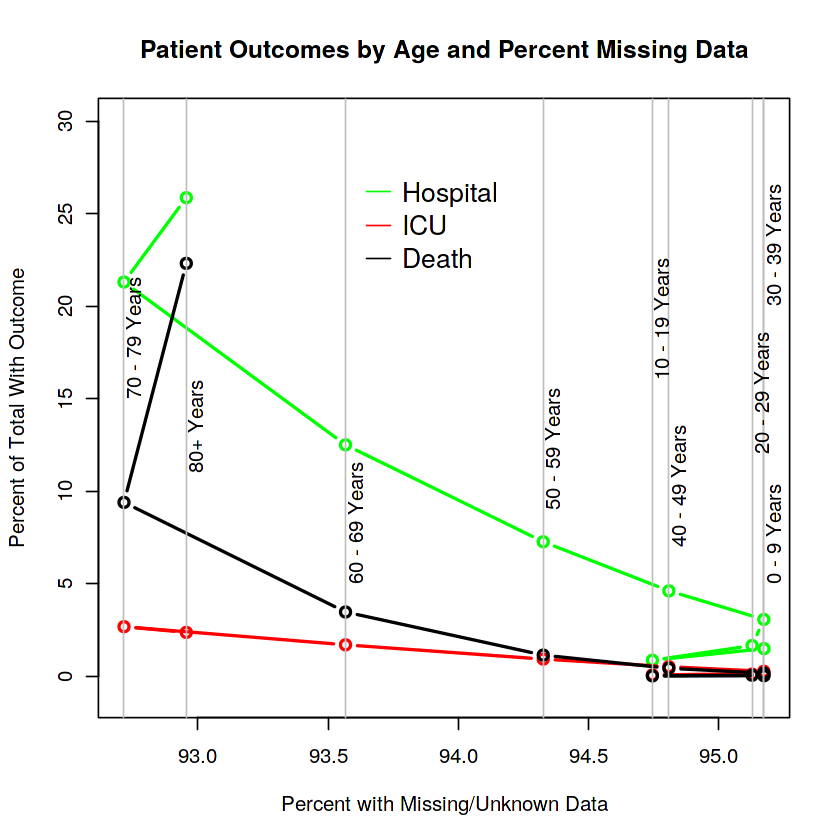

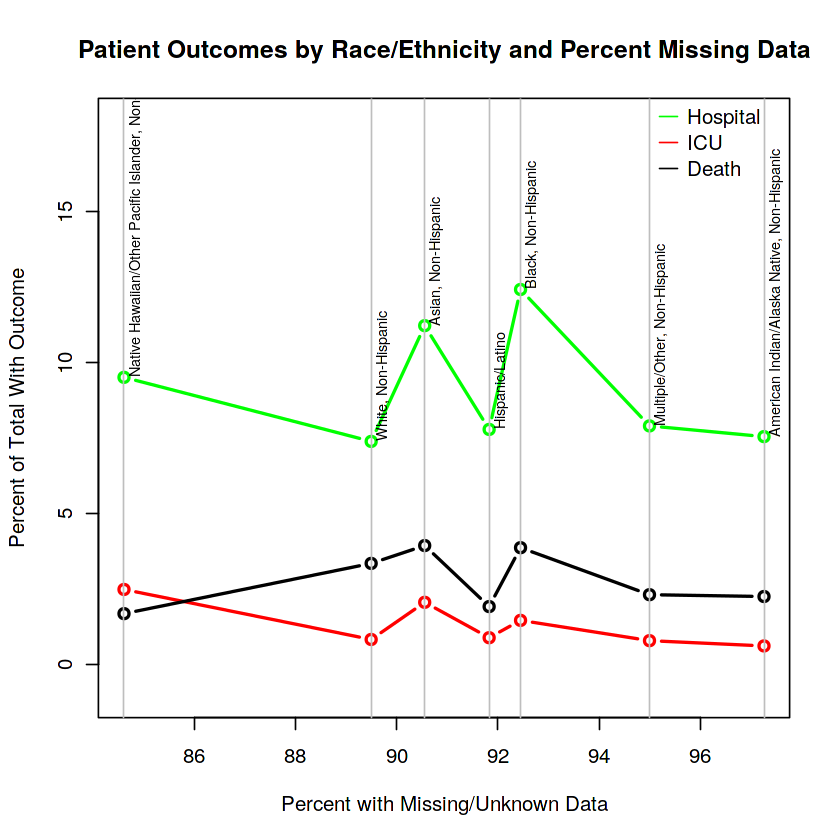

In [12]:
# Plot age & outcomes
a <- Age_outcomes
plot(a$percent_lost, a$p_hosp, type = "b", col = "green", lwd = 2,
     xlab = "Percent with Missing/Unknown Data", 
     ylab = "Percent of Total With Outcome", main = "Patient Outcomes by Age and Percent Missing Data", 
    ylim=c(-1, 30))
lines(a$percent_lost, a$p_icu, type = "b", lwd = 2,col = "red")
lines(a$percent_lost, a$p_death, type = "b", lwd = 2,col = "black")
legend(93.6,28, legend=c("Hospital", "ICU", "Death"),
       col=c("green", "red", "black"), lty=1, bty="n", cex = 1.3)
abline(v=a$percent_lost, col=c("grey"), lty=c(1))
coords <- c(5, 16, 12, 20, 7,9, 5, 15, 11)
for (i in 1:9){
    text(a$percent_lost[i], coords[i], toString(a$age[i]), pos = c(4,3,2,4,2,3,3,3,3), srt=90)
}

# Plot Race/Ethnicity & Outcomes
r <- RE_outcomes[order(RE_outcomes$percent_lost),]
plot(r$percent_lost, r$p_hosp, type = "b", col = "green", lwd = 2,
     xlab = "Percent with Missing/Unknown Data", 
     ylab = "Percent of Total With Outcome", 
    ylim=c(-1, 18),
    main = "Patient Outcomes by Race/Ethnicity and Percent Missing Data",)
lines(r$percent_lost, r$p_icu, type = "b", lwd = 2,col = "red")
lines(r$percent_lost, r$p_death, type = "b", lwd = 2,col = "black")
legend(95,19, legend=c("Hospital", "ICU", "Death"),
       col=c("green", "red", "black"), lty=1, bty="n")
abline(v=r$percent_lost, col=c("grey"), lty=c(1))
#coords <- c(5, 15, 12, 20, 8,9, 5, 15, 11)
for (i in 1:9){
    text(r$percent_lost[i], r$p_hosp[i], toString(r$race_ethnicity[i]), pos = c(4,4,4,4,1,4,4), srt=90, cex = .7)
}

Less data was acquired in younger patients.  Perhaps this was due to less information about, say, pre-existing medical conditions, and fewer younger patients required the more advanced care.

We can see here there is a negative relationship between age groups with missing entries in the data and hospital/ICU/death rates.

However, when considering race/ethnic groups, there is not such a relationship.  Some race/ethnic groups had significantly more missing data than others.  Disease outcomes, most notably hospitalization, also varied greatly across race/ethnic groups. 

Some patterns of note:
* People categorized as Asian or Black have higher rates of poor disease outcomes.
* People categorized as Native Hawaiian/Pacific Islander have lower rates of missing data.  This may be due to lower rates of covid in Hawaii, resulting in a better capacity for hospital staff to record more details of patients.
* People categorized as American Indian/ Alaskan Native had the highest rate of missing data, at 97%, more than 2% more than the next group (race/ethnicity recorded as Multiple/Other). This may also be connected to regional hospital staff capacity to record detailed data.



The proportion test provides a p-value of 2.2e-16, which suggests that the differences in race/ethnic groups' rates of missing data are not due to chance.  Of course, this result is not surprising, as the identical investigation into differences in data completion for age groups found a differences within 1-2% to also not be due to chance.  However, it is noteworthy that the data discrepancies between age groups are much smaller than those for ethnic groups.  Additionally, the age groups most at risk for disease complications (older decades) had more thorough records, while the opposite is true regarding risk level and race/ethnicity (see models below).

Possible explanations for missing data:
* communication/language barriers
* hospital recording methods
* hospital recording dilligence (keeping in mind how many hospitals have been short of staff, etc.)

It is unfortunate to have such discrepancies in the data.  We may consider minimizing these.  There is more 'Missing' or 'Unknown' data from the ICU variable and the MedCond variable than any other.  

Regarding the ICU variable, I suspect that different hospitals had different methods for whether or not this data was recorded/included.  Next I will investigate whether the ICU variable provides more information than Hosp or Death.  In other words, does the ICU data have a strong additional influence on predictions?

Regarding Medcond, there is no alternative to this information, but later we can investigate if it is a strong predictor of patient outcomes.



In [13]:
# Compare Hosp, ICU, & Death for rows in which there is no missing data.
HID <- df[,5:7]
#unique(HID) # check all entries are 'Yes' or 'No'
HID <- ifelse(HID == 'Yes', 1, 0)

cor(HID[,1], HID[,2])
cor(HID[,2], HID[,3])
cor(HID[,1], HID[,3])

[1] 0.538724

[1] 0.5241059

[1] 0.4656023

We find a modest correlation between hosp & ICU and between death & ICU.  There is an even lower correlation between hosp and death (which is intuitive).  However, this leaves a moderate predictive power for hosp or death to take the place of the missing ICU entries.

Given this, I will continue with the analysis only for the non-missing/unknown data.  I will do a similar investigation with the removal of ICU and Medcond as predictors to include a larger amount of data.

In [14]:
## https://datascienceplus.com/perform-logistic-regression-in-r/

library(caret)
#df <- ifelse(df[5:7] == 'Yes', 1, 0)



Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    progress




In [15]:
# factorize variables to remove "Missing" and "Unknown" levels
for (i in 1:8){
    df[,i] <- factor(df[,i])
}


In [16]:
head(df)

,current_status,sex,age,race_ethnicity,hosp,icu,death,medcond
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,No,No,No
2,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,No,No,No
3,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,No,No,Yes
4,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,No,No,No
5,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,No,No,Yes
6,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,No,No,No


In [17]:
# predict hosp
set.seed(100)
intrain<-createDataPartition(y=df$hosp,p=0.7,list=FALSE)
training<-df[intrain,]
testing<-df[-intrain,]


In [18]:
# caret bayesglm model

# this takes a long time to run
# age 20 - 69 -higher pval
# 70s, 80s strongest predictor (by coefficient)
# all race_eth negative coef besides Native, which is also the group with the 
# least detailed data collection.  Perhaps outcomes are more closely related to hospital conditions 
# compared to race_ethn.  Similarly, being white reduces the most
tic()
bayes_hosp_model <- train(hosp ~ age + sex + race_ethnicity + medcond - 1, 
                 method = "bayesglm",data=training)
toc() # ~200 seconds
# this does nothing, but why?  preobj <- preProcess(training[,-5],method = c("pca"), thresh = .9)
#preobj$numComp

summary(bayes_hosp_model)
# model accuracy
confusionMatrix(predict(bayes_hosp_model, training[,]), reference=training$hosp) # Accuracy 84%

176.543 sec elapsed



Call:
NULL

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9198  -0.5759  -0.3272  -0.1683   3.1596  

Coefficients:
                                                                     Estimate
(Intercept)                                                          -1.98260
`age0 - 9 Years`                                                     -1.23050
`age10 - 19 Years`                                                   -1.78314
`age20 - 29 Years`                                                   -1.04855
`age30 - 39 Years`                                                   -0.50018
`age40 - 49 Years`                                                   -0.10887
`age50 - 59 Years`                                                    0.38279
`age60 - 69 Years`                                                    0.99788
`age70 - 79 Years`                                                    1.71583
`age80+ Years`                                                        2.17172
s

Confusion Matrix and Statistics

          Reference
Prediction     No    Yes
       No  249926  39304
       Yes  12197  18985
                                         
               Accuracy : 0.8393         
                 95% CI : (0.838, 0.8405)
    No Information Rate : 0.8181         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.3408         
                                         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
            Sensitivity : 0.9535         
            Specificity : 0.3257         
         Pos Pred Value : 0.8641         
         Neg Pred Value : 0.6088         
             Prevalence : 0.8181         
         Detection Rate : 0.7800         
   Detection Prevalence : 0.9027         
      Balanced Accuracy : 0.6396         
                                         
       'Positive' Class : No             
                                

In [19]:
# decision tree 
# note: cannot run random forest on my computer
tic()
caret_rpart_hosp_model <- train(hosp ~ age + sex + race_ethnicity + medcond - 1, 
                 method = "rpart",data=training)
toc() # ~100 sec
#summary(caret_rpart_hosp_model)

confusionMatrix(predict(caret_rpart_hosp_model, training[,]), reference=training$hosp) #also ~84%


127.591 sec elapsed


Confusion Matrix and Statistics

          Reference
Prediction     No    Yes
       No  253390  43900
       Yes   8733  14389
                                         
               Accuracy : 0.8357         
                 95% CI : (0.8344, 0.837)
    No Information Rate : 0.8181         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.279          
                                         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
            Sensitivity : 0.9667         
            Specificity : 0.2469         
         Pos Pred Value : 0.8523         
         Neg Pred Value : 0.6223         
             Prevalence : 0.8181         
         Detection Rate : 0.7908         
   Detection Prevalence : 0.9278         
      Balanced Accuracy : 0.6068         
                                         
       'Positive' Class : No             
                                

In [20]:
# GLM predict hosp
tic()
glm_hosp_model <- glm(hosp ~ factor(age) + factor(sex) + factor(race_ethnicity) + medcond - 1, 
                  family="binomial",data=training)
toc() # ~2 sec
summary(glm_hosp_model)

#test_glm_hosp <- predict(glm_hosp_model, testing[,], type = "response")
train_pred <- predict(glm_hosp_model, training[,-5], type = "response")
#summary(train_pred)

binary_train_pred <- ifelse(train_pred > 0.5,1,0)
#summary(train_pred)


binary_train_hosp <- ifelse(training$hosp == "Yes",1,0)
levels(binary_train_hosp) <- c(0,1) 
levels(binary_train_pred) <- c(0,1) 

binary_train_hosp <- factor(binary_train_hosp)
binary_train_pred <- factor(binary_train_pred)

confusionMatrix(binary_train_pred, reference=binary_train_hosp) #also ~84%

1.635 sec elapsed



Call:
glm(formula = hosp ~ factor(age) + factor(sex) + factor(race_ethnicity) + 
    medcond - 1, family = "binomial", data = training)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9218  -0.5759  -0.3272  -0.1683   3.1598  

Coefficients:
                                                                           Estimate
factor(age)0 - 9 Years                                                     -3.20933
factor(age)10 - 19 Years                                                   -3.76177
factor(age)20 - 29 Years                                                   -3.02674
factor(age)30 - 39 Years                                                   -2.47830
factor(age)40 - 49 Years                                                   -2.08695
factor(age)50 - 59 Years                                                   -1.59526
factor(age)60 - 69 Years                                                   -0.98013
factor(age)70 - 79 Years                                      

Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0 249926  39304
         1  12197  18985
                                         
               Accuracy : 0.8393         
                 95% CI : (0.838, 0.8405)
    No Information Rate : 0.8181         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.3408         
                                         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
            Sensitivity : 0.9535         
            Specificity : 0.3257         
         Pos Pred Value : 0.8641         
         Neg Pred Value : 0.6088         
             Prevalence : 0.8181         
         Detection Rate : 0.7800         
   Detection Prevalence : 0.9027         
      Balanced Accuracy : 0.6396         
                                         
       'Positive' Class : 0              
                                

In [21]:
# ROC evaluation
library(ROCR)


[1] 0.8282797

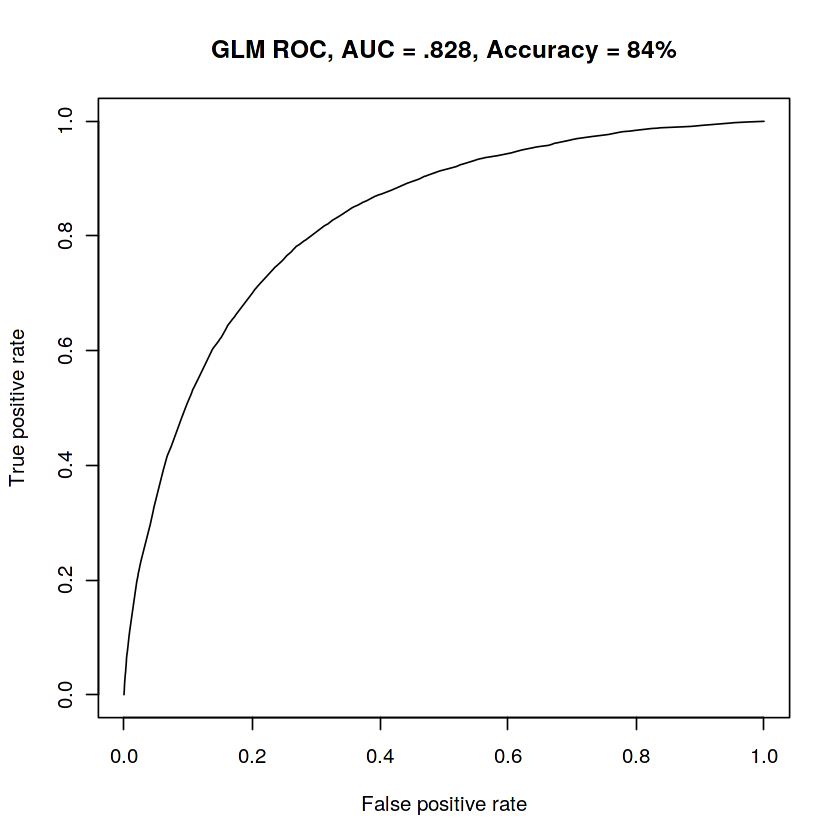

In [22]:
# GLM ROC
pr <- prediction(train_pred, binary_train_hosp)
prf <- performance(pr, measure = "tpr", x.measure = "fpr")
plot(prf, main = "GLM ROC, AUC = .828, Accuracy = 84%")

auc <- performance(pr, measure = "auc")
auc <- auc@y.values[[1]]
auc # 0.828

[1] 0.7449411

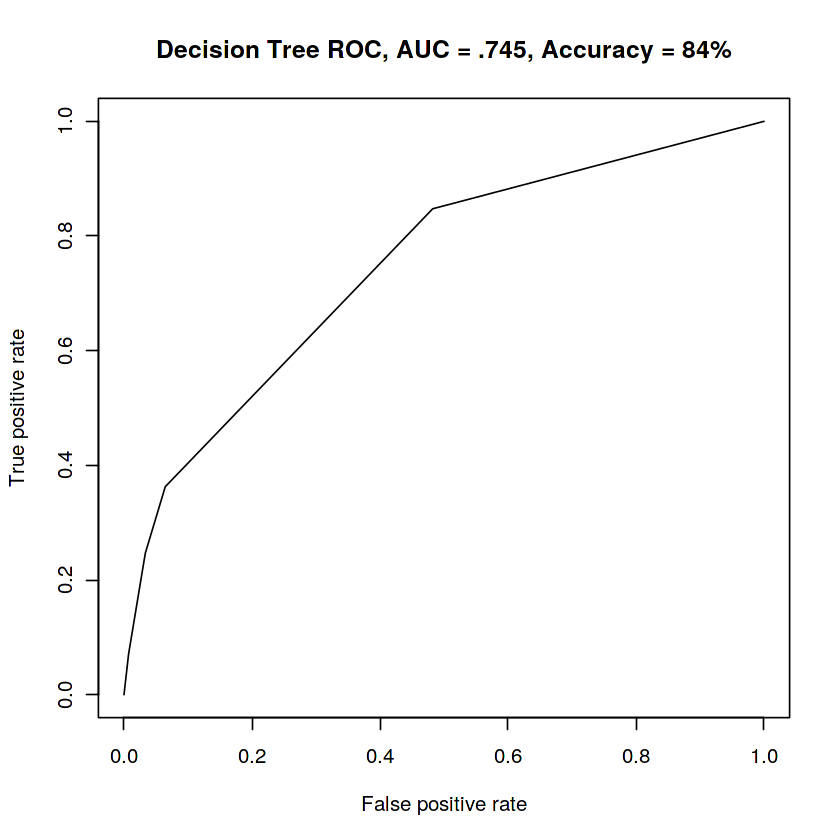

In [23]:
# rpart Decision Tree ROC

dt_pred <- predict(caret_rpart_hosp_model, training[,], type = "prob")
#head(dt_pred)

dt_pr <- prediction(dt_pred[,2],training$hosp)
dt_prf <- performance(dt_pr, measure = "tpr", x.measure = "fpr")
plot(dt_prf, main = "Decision Tree ROC, AUC = .745, Accuracy = 84%")

dt_auc <- performance(dt_pr, measure = "auc")
dt_auc <- dt_auc@y.values[[1]]
dt_auc # 0.745


[1] 0.8282836

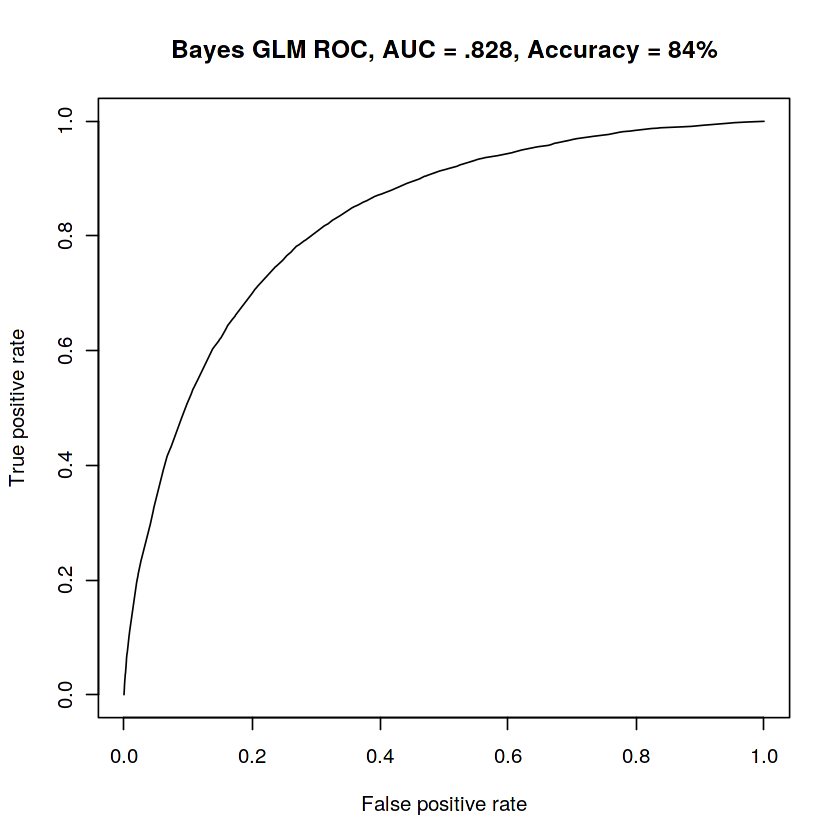

In [24]:
# caret Bayes GLM ROC

bayes_pred <- predict(bayes_hosp_model, training[,], type = "prob")
#head(bayes_pred)

bayes_pr <- prediction(bayes_pred[,2],training$hosp)
bayes_prf <- performance(bayes_pr, measure = "tpr", x.measure = "fpr")
plot(bayes_prf, main = "Bayes GLM ROC, AUC = .828, Accuracy = 84%")

b_auc <- performance(bayes_pr, measure = "auc")
b_auc <- b_auc@y.values[[1]]
b_auc # 0.828


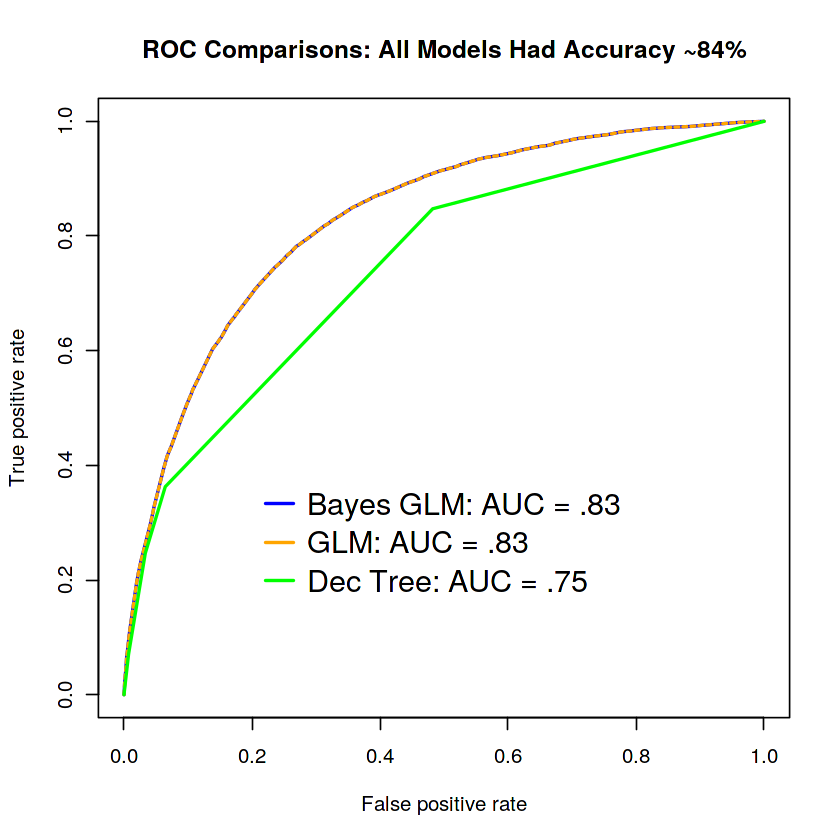

In [25]:
plot( bayes_prf, col = "blue", lwd = 2, alpha = .8, main = "ROC Comparisons: All Models Had Accuracy ~84%")
plot(prf, add = TRUE, col= "orange", lty= "dashed", lwd = 2, alpha = .2)
plot(dt_prf, add = TRUE, col= "green", lwd = 2)
legend(0.2, 0.4, legend=c("Bayes GLM: AUC = .83", "GLM: AUC = .83", "Dec Tree: AUC = .75"),
       col=c("blue", "orange", "green"), lty=c(1,1,1), lwd = 2, bty = "n", cex = 1.5)

The two GLM models perform equally well, and are better than the Decision Tree for predicting a hospital outcome from demographic and medical condition data.  The Bayes GLM model under the caret package had a processing time of approximately 200 seconds.  The other GLM model had a processing time of two seconds, so this is a more efficient way to generate the linear model.

Continuing with this GLM model, we can evaluate how data on medical conditions and ICU stays influences the model in predicting patient death.

In [26]:
head(training)

,current_status,sex,age,race_ethnicity,hosp,icu,death,medcond
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,No,No,No
2,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,No,No,No
3,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,No,No,Yes
4,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,No,No,No
5,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,No,No,Yes
6,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,No,No,No


In [27]:
# GLM predict death

# predict with hosp, icu, & medcond
tic()
glm_death_model <- glm(death ~ factor(age) + factor(sex) + factor(race_ethnicity) + hosp + icu+ medcond - 1, 
                  family="binomial",data=training)
toc() # ~4 sec
#summary(glm_death_model)

train_pred <- predict(glm_death_model, training[,-7], type = "response")
#summary(train_pred)

binary_train_pred <- ifelse(train_pred > 0.5,1,0)
#summary(train_pred)


binary_train_death <- ifelse(training$death == "Yes",1,0)
levels(binary_train_death) <- c(0,1) 
levels(binary_train_pred) <- c(0,1) 

binary_train_death <- factor(binary_train_death)
binary_train_pred <- factor(binary_train_pred)

confusionMatrix(binary_train_pred, reference=binary_train_death) #95% accuracy, Sensitivity : 0.980, Specificity : 0.5195 

2.494 sec elapsed


Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0 294031   9791
         1   6005  10585
                                          
               Accuracy : 0.9507          
                 95% CI : (0.9499, 0.9514)
    No Information Rate : 0.9364          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5468          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9800          
            Specificity : 0.5195          
         Pos Pred Value : 0.9678          
         Neg Pred Value : 0.6380          
             Prevalence : 0.9364          
         Detection Rate : 0.9177          
   Detection Prevalence : 0.9482          
      Balanced Accuracy : 0.7497          
                                          
       'Positive' Class : 0               
            

In [28]:
# GLM predict death

# predict with hosp, without icu, & medcond
glm_death_model_2 <- glm(death ~ factor(age) + factor(sex) + factor(race_ethnicity) + hosp  - 1, 
                  family="binomial",data=training)


train_pred <- predict(glm_death_model_2, training[,-7], type = "response")
#summary(train_pred)

binary_train_pred <- ifelse(train_pred > 0.5,1,0)
#summary(train_pred)


binary_train_death <- ifelse(training$death == "Yes",1,0)
levels(binary_train_death) <- c(0,1) 
levels(binary_train_pred) <- c(0,1) 

binary_train_death <- factor(binary_train_death)
binary_train_pred <- factor(binary_train_pred)

confusionMatrix(binary_train_pred, reference=binary_train_death) #94% accuracy, Sensitivity : 0.9805, Specificity : 0.3576 

Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0 294189  13089
         1   5847   7287
                                          
               Accuracy : 0.9409          
                 95% CI : (0.9401, 0.9417)
    No Information Rate : 0.9364          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.4053          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9805          
            Specificity : 0.3576          
         Pos Pred Value : 0.9574          
         Neg Pred Value : 0.5548          
             Prevalence : 0.9364          
         Detection Rate : 0.9182          
   Detection Prevalence : 0.9590          
      Balanced Accuracy : 0.6691          
                                          
       'Positive' Class : 0               
            

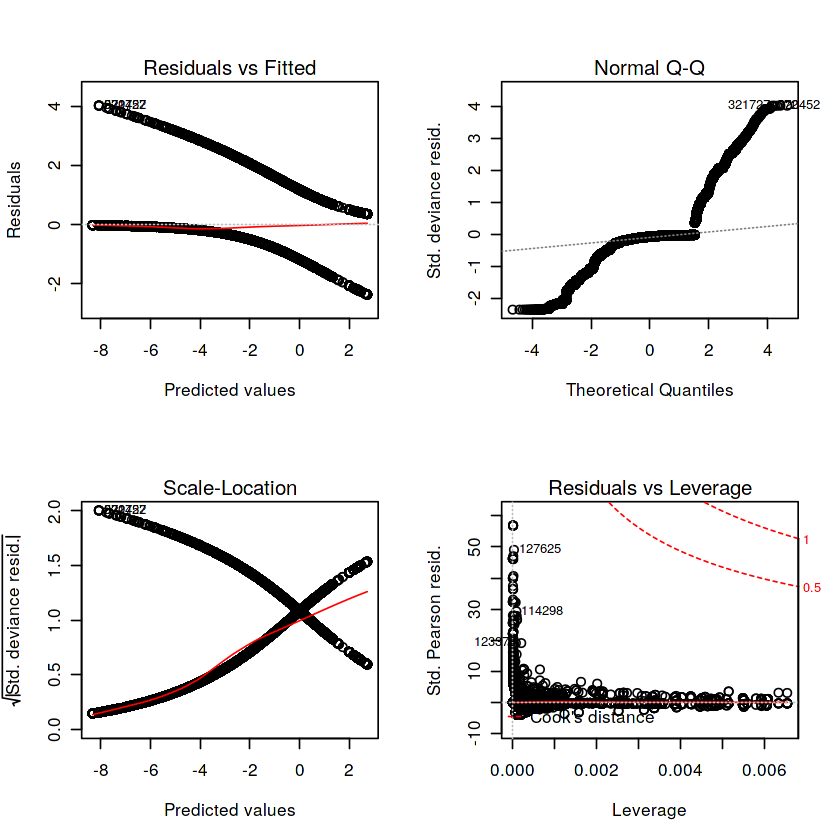

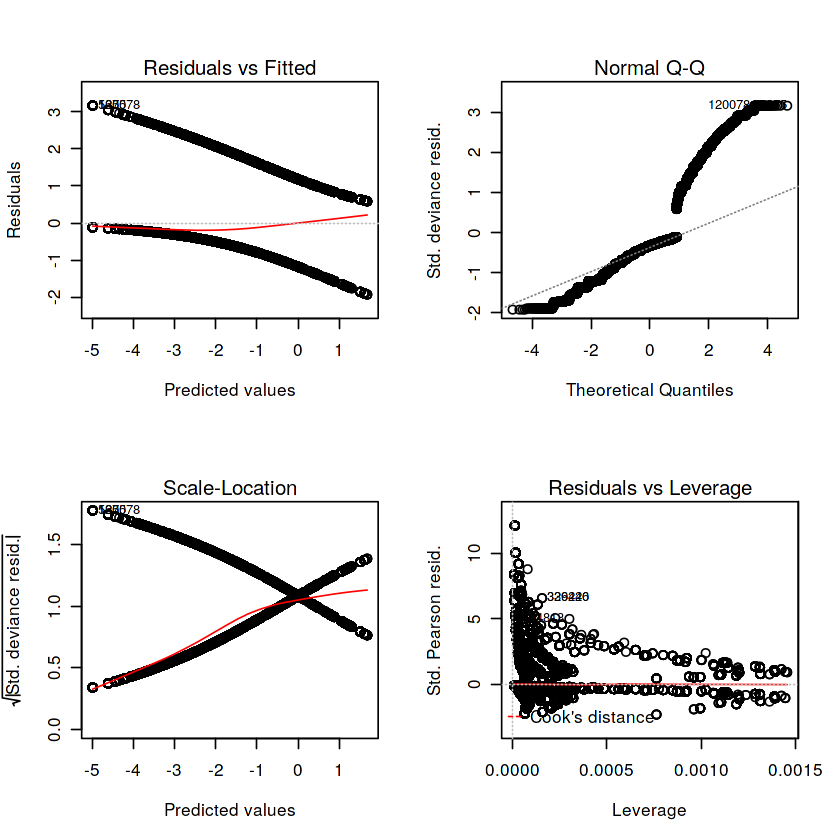

In [29]:
par(mfrow = c(2, 2))
plot(glm_death_model)
par(mfrow = c(2, 2))
plot(glm_hosp_model)

## Applying Models to Test Sets

In [30]:
# Bayes GLM test
bayes_test <- predict(bayes_hosp_model, testing[,], type = "prob")
confusionMatrix(predict(bayes_hosp_model, testing[,]), reference=testing$hosp) # Accuracy 83%


Confusion Matrix and Statistics

          Reference
Prediction     No    Yes
       No  107137  17033
       Yes   5201   7948
                                        
               Accuracy : 0.8381        
                 95% CI : (0.8361, 0.84)
    No Information Rate : 0.8181        
    P-Value [Acc > NIR] : < 2.2e-16     
                                        
                  Kappa : 0.3332        
                                        
 Mcnemar's Test P-Value : < 2.2e-16     
                                        
            Sensitivity : 0.9537        
            Specificity : 0.3182        
         Pos Pred Value : 0.8628        
         Neg Pred Value : 0.6045        
             Prevalence : 0.8181        
         Detection Rate : 0.7802        
   Detection Prevalence : 0.9042        
      Balanced Accuracy : 0.6359        
                                        
       'Positive' Class : No            
                                        

In [31]:
htest <- predict(glm_hosp_model, testing[,-5], type = "response")

binary_htest <- ifelse(htest > 0.5,1,0)

binary_testing_h <- ifelse(testing$hosp == "Yes",1,0)
levels(binary_htest) <- c(0,1) 
levels(binary_testing_h) <- c(0,1) 

binary_htest <- factor(binary_htest)
binary_testing_h <- factor(binary_testing_h)

confusionMatrix(binary_htest, reference=binary_testing_h) #also ~84%

Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0 107137  17033
         1   5201   7948
                                        
               Accuracy : 0.8381        
                 95% CI : (0.8361, 0.84)
    No Information Rate : 0.8181        
    P-Value [Acc > NIR] : < 2.2e-16     
                                        
                  Kappa : 0.3332        
                                        
 Mcnemar's Test P-Value : < 2.2e-16     
                                        
            Sensitivity : 0.9537        
            Specificity : 0.3182        
         Pos Pred Value : 0.8628        
         Neg Pred Value : 0.6045        
             Prevalence : 0.8181        
         Detection Rate : 0.7802        
   Detection Prevalence : 0.9042        
      Balanced Accuracy : 0.6359        
                                        
       'Positive' Class : 0             
                                        

In [32]:
d1test <- predict(glm_death_model, testing[,-7], type = "response")
binary_d1test <- ifelse(d1test > 0.5,1,0)

binary_testing_d <- ifelse(testing$death == "Yes",1,0)
levels(binary_d1test) <- c(0,1) 
levels(binary_testing_d) <- c(0,1) 

binary_d1test <- factor(binary_d1test)
binary_testing_d <- factor(binary_testing_d)

confusionMatrix(binary_d1test, reference=binary_testing_d) # accuracy 95%

d2test <- predict(glm_death_model_2, testing[,-7], type = "response")
binary_d2test <- ifelse(d2test > 0.5,1,0)
levels(binary_d2test) <- c(0,1) 
binary_d2test <- factor(binary_d2test)
confusionMatrix(binary_d2test, reference=binary_testing_d) #also ~94%




Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0 125916   4373
         1   2610   4420
                                         
               Accuracy : 0.9491         
                 95% CI : (0.948, 0.9503)
    No Information Rate : 0.936          
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.5321         
                                         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
            Sensitivity : 0.9797         
            Specificity : 0.5027         
         Pos Pred Value : 0.9664         
         Neg Pred Value : 0.6287         
             Prevalence : 0.9360         
         Detection Rate : 0.9170         
   Detection Prevalence : 0.9488         
      Balanced Accuracy : 0.7412         
                                         
       'Positive' Class : 0              
                                

Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0 126048   5759
         1   2478   3034
                                          
               Accuracy : 0.94            
                 95% CI : (0.9387, 0.9413)
    No Information Rate : 0.936           
    P-Value [Acc > NIR] : 3.137e-10       
                                          
                  Kappa : 0.3943          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9807          
            Specificity : 0.3450          
         Pos Pred Value : 0.9563          
         Neg Pred Value : 0.5504          
             Prevalence : 0.9360          
         Detection Rate : 0.9179          
   Detection Prevalence : 0.9599          
      Balanced Accuracy : 0.6629          
                                          
       'Positive' Class : 0               
            

## Conclusion

The GLM models for predicting hospitalization and death all performed well on the test sets.  Specificity values ranged from around 30% to 50%.  Sensitivity values were all at least 95%.  

The GLM model is highly predictive.  ICU and medcond data is beneficial in predicting death as a patient outcome.  While it is the case that these factors were often not included in patients' data, it is slightly beneficial for predicting future patient outcomes to keep record of this data.

The GLM model from the caret package was similarly predictive to the base R GLM model, however, the latter is a signficantly faster, and therefore a better choice with this data.



In [33]:
# Prediction out of curiousity for my friend with a recent covid exposure:

Michael_data <- testing[14750,] # matches Michael info (sex, age, race)
Michael_data_medcond <- testing[14760,] # matches Michael + medcond to give more conservative prediction

print("hospitalization probabilities without and with a medical condition")
predict(bayes_hosp_model, Michael_data, type = "prob")

predict(bayes_hosp_model, Michael_data_medcond, type = "prob")

print("death probabilities without and with a medical condition")

predict(glm_death_model_2, Michael_data, type = "response")
predict(glm_death_model_2, Michael_data_medcond, type = "response") #interestingly, identical to prediction without medcond, ~0.2%


[1] "hospitalization probabilities without and with a medical condition"


,No,Yes
,<dbl>,<dbl>
49864,0.9653291,0.03467091


,No,Yes
,<dbl>,<dbl>
49905,0.9020832,0.09791677


[1] "death probabilities without and with a medical condition"


49864 
0.002649411

49905 
0.002649411